# Multi-Objective Reservoir Optimization Showcase

This notebook demonstrates multi-objective optimization for a realistic water system using taqsim.

**System Configuration:**
- **72 optimizable parameters**: 60 SLOP release rule + 12 SeasonalRatio split rule
- **2 objectives**: maximize hydropower, minimize city flooding
- **120 timesteps**: 10 years × 12 months
- **9 nodes, 8 edges**: realistic water network topology

**Why 2 objectives?**

Analysis showed that with this topology:
- **Hydropower** and **deficits** are *aligned* (both improve with more release)
- **City flood** opposes them (wants less release)

This creates a single fundamental trade-off: **release level**. Using 4 objectives added redundancy without new trade-off dimensions.

The optimization uses NSGA-II to find Pareto-optimal trade-offs between hydropower generation and flood risk.

In [ ]:
from dataclasses import dataclass
from typing import ClassVar

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

from taqsim import (
    Demand,
    Edge,
    Frequency,
    LossReason,
    Objective,
    Ordered,
    PassThrough,
    Sink,
    Source,
    Splitter,
    Storage,
    Strategy,
    TimeSeries,
    Timestep,
    WaterSystem,
    lift,
    optimize,
)
from taqsim.node.events import WaterPassedThrough, WaterSpilled, WaterStored

TIMESTEPS = 120
SEED = 96530  # From exploration trial 0

## Time Series Generation

Generate realistic seasonal patterns for river inflows and demands:
- **Inflows**: Peak in summer (months 5-7), low in winter, with random variability and occasional extreme events
- **Irrigation demand**: Peak in summer growing season (months 6-8), zero in winter
- **Thermal demand**: Higher in summer (more cooling needed), relatively stable baseline

In [2]:
# Configuration from exploration trial 0
INFLOW_SCALE = 0.89
IRRIGATION_PEAK = 25.4
THERMAL_BASE = 24.1
CITY_CAPACITY = 41.0


def generate_inflows(n_years: int = 10, mean_annual: float = 100.0, seed: int = 42) -> list[float]:
    """Generate monthly river inflows with seasonal pattern and variability."""
    rng = np.random.default_rng(seed)
    seasonal = [0.5, 0.6, 0.8, 1.2, 1.6, 1.8, 1.5, 1.0, 0.7, 0.5, 0.4, 0.4]

    inflows = []
    for year in range(n_years):
        year_factor = rng.uniform(0.8, 1.2)
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            extreme = 1.8 if rng.random() < 0.08 else 1.0
            inflows.append(mean_annual * s * year_factor * noise * extreme)
    return inflows


def generate_irrigation_demand(n_years: int = 10, peak_demand: float = 25.0, seed: int = 123) -> list[float]:
    """Generate monthly irrigation demand with growing season pattern."""
    rng = np.random.default_rng(seed)
    seasonal = [0.0, 0.0, 0.2, 0.6, 1.0, 1.4, 1.5, 1.2, 0.7, 0.2, 0.0, 0.0]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.9, 1.1)
            demand.append(peak_demand * s * noise)
    return demand


def generate_thermal_demand(n_years: int = 10, base_demand: float = 24.0, seed: int = 456) -> list[float]:
    """Generate thermal plant cooling demand - higher in summer when more cooling is needed."""
    rng = np.random.default_rng(seed)
    seasonal = [0.7, 0.7, 0.8, 0.9, 1.1, 1.3, 1.4, 1.3, 1.1, 0.9, 0.8, 0.7]

    demand = []
    for year in range(n_years):
        for month, s in enumerate(seasonal):
            noise = rng.uniform(0.95, 1.05)
            demand.append(base_demand * s * noise)
    return demand


inflows = generate_inflows(n_years=10, mean_annual=100.0 * INFLOW_SCALE, seed=SEED)
irrigation_demand = generate_irrigation_demand(n_years=10, peak_demand=IRRIGATION_PEAK, seed=SEED + 1)
thermal_demand = generate_thermal_demand(n_years=10, base_demand=THERMAL_BASE, seed=SEED + 2)

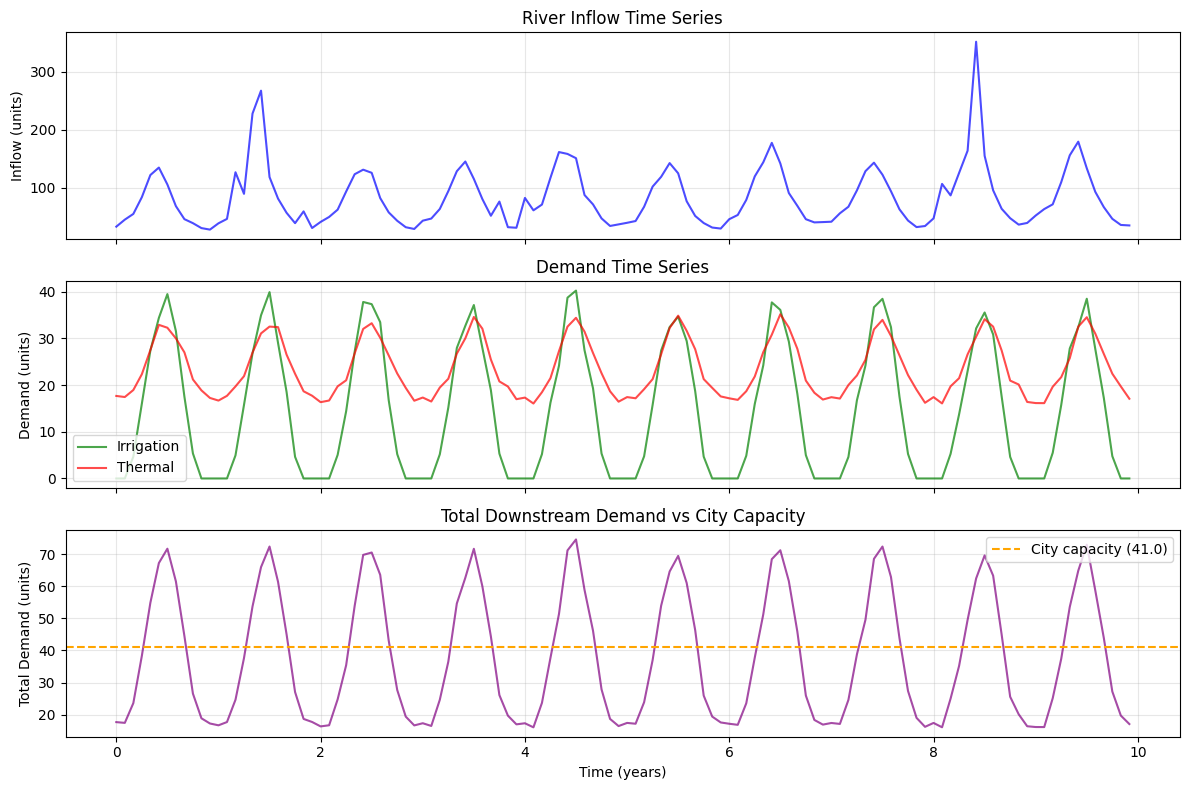

In [3]:
fig, axes = plt.subplots(3, 1, figsize=(12, 8), sharex=True)

months = np.arange(TIMESTEPS)
years = months / 12

axes[0].plot(years, inflows, "b-", alpha=0.7)
axes[0].set_ylabel("Inflow (units)")
axes[0].set_title("River Inflow Time Series")
axes[0].grid(True, alpha=0.3)

axes[1].plot(years, irrigation_demand, "g-", alpha=0.7, label="Irrigation")
axes[1].plot(years, thermal_demand, "r-", alpha=0.7, label="Thermal")
axes[1].set_ylabel("Demand (units)")
axes[1].set_title("Demand Time Series")
axes[1].legend()
axes[1].grid(True, alpha=0.3)

axes[2].plot(years, [sum(x) for x in zip(irrigation_demand, thermal_demand, strict=True)], "purple", alpha=0.7)
axes[2].axhline(y=CITY_CAPACITY, color="orange", linestyle="--", label=f"City capacity ({CITY_CAPACITY})")
axes[2].set_ylabel("Total Demand (units)")
axes[2].set_xlabel("Time (years)")
axes[2].set_title("Total Downstream Demand vs City Capacity")
axes[2].legend()
axes[2].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

## Custom Strategies

### SLOP Release Rule (60 parameters)
Storage Level Operating Policy with time-varying parameters. For each of 12 months, defines:
- `h1`, `h2`: Water level thresholds (low and high)
- `w`: Base release rate
- `m1`: Slope below h1 (conservation zone)
- `m2`: Slope above h2 (flood control zone)

### SeasonalRatio Split Rule (12 parameters)
Monthly varying split between irrigation and thermal plant cooling:
- `irrigation_fraction`: Fraction allocated to irrigation (remainder to thermal)

In [ ]:
def volume_to_head(
    volume: float, v_dead: float = 10.0, v_max: float = 150.0, h_dead: float = 20.0, h_max: float = 100.0
) -> float:
    """Convert reservoir volume to hydraulic head (water level)."""
    v_clamped = max(v_dead, min(v_max, volume))
    return h_dead + (v_clamped - v_dead) * (h_max - h_dead) / (v_max - v_dead)


@dataclass(frozen=True)
class SLOPRelease(Strategy):
    """Storage Level Operating Policy with time-varying monthly parameters."""

    __params__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {
        "h1": (20.0, 100.0),
        "h2": (20.0, 100.0),
        "w": (0.0, 80.0),
        "m1": (0.01, 2.0),
        "m2": (0.01, 2.0),
    }
    __constraints__: ClassVar[tuple] = (Ordered(low="h1", high="h2"),)
    __time_varying__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __cyclical__: ClassVar[tuple[str, ...]] = ("h1", "h2", "w", "m1", "m2")
    __cyclical_freq__: ClassVar[dict[str, Frequency]] = {
        "h1": Frequency.MONTHLY,
        "h2": Frequency.MONTHLY,
        "w": Frequency.MONTHLY,
        "m1": Frequency.MONTHLY,
        "m2": Frequency.MONTHLY,
    }

    h1: tuple[float, ...] = (40.0,) * 12
    h2: tuple[float, ...] = (70.0,) * 12
    w: tuple[float, ...] = (40.0,) * 12
    m1: tuple[float, ...] = (0.5,) * 12
    m2: tuple[float, ...] = (0.8,) * 12

    def release(self, node: Storage, inflow: float, t: Timestep) -> float:
        head = volume_to_head(node.storage)

        h1_t = self.param_at("h1", t)
        h2_t = self.param_at("h2", t)
        w_t = self.param_at("w", t)
        m1_t = self.param_at("m1", t)
        m2_t = self.param_at("m2", t)

        # Piecewise linear SLOP policy
        if head < h1_t:
            # Conservation zone: reduce release linearly
            release = max(0.0, w_t - m1_t * (h1_t - head))
        elif head > h2_t:
            # Flood control zone: increase release linearly
            release = w_t + m2_t * (head - h2_t)
        else:
            # Normal zone: release at base rate
            release = w_t

        # Cannot release more than available (above dead storage)
        available = max(0.0, node.storage - node.dead_storage)
        return min(release, available)


@dataclass(frozen=True)
class SeasonalRatio(Strategy):
    """Time-varying split ratio between irrigation and thermal plant."""

    __params__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __bounds__: ClassVar[dict[str, tuple[float, float]]] = {"irrigation_fraction": (0.1, 0.9)}
    __time_varying__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __cyclical__: ClassVar[tuple[str, ...]] = ("irrigation_fraction",)
    __cyclical_freq__: ClassVar[dict[str, Frequency]] = {
        "irrigation_fraction": Frequency.MONTHLY,
    }

    irrigation_fraction: tuple[float, ...] = (0.5,) * 12

    def split(self, node: Splitter, amount: float, t: Timestep) -> dict[str, float]:
        frac = self.param_at("irrigation_fraction", t)
        return {
            "irrigation": amount * frac,
            "thermal_plant": amount * (1.0 - frac),
        }


# Count optimizable parameters
slop_params = 5 * 12  # 5 params x 12 months
ratio_params = 1 * 12  # 1 param x 12 months
print(f"SLOP parameters: {slop_params}")
print(f"SeasonalRatio parameters: {ratio_params}")
print(f"Total optimizable parameters: {slop_params + ratio_params}")

## Objectives

We optimize two objectives that represent the core trade-off in reservoir operations:

### 1. Hydropower (maximize)
Total electricity generated at the turbine over 120 months.

**Formula:** `Power = flow × head × efficiency × gravity`
- **flow**: Water passing through turbine (from reservoir release)
- **head**: Hydraulic head based on reservoir storage level

**Trade-off:** Wants high release for high flow, but excessive release depletes reservoir → lower head.

### 2. City Flood Risk (minimize)
Total water spillage at the city passthrough when flow exceeds capacity (41 units).

**Trade-off:** Wants low release to stay under capacity, directly conflicts with hydropower.

In [5]:
from taqsim.node.events import WaterReleased


@lift
def volume_to_head_lifted(v: float) -> float:
    """Lifted version for trace arithmetic."""
    return 20.0 + (max(10.0, min(150.0, v)) - 10.0) * 80.0 / 140.0


def hydropower_objective(
    reservoir_id: str, turbine_id: str, initial_storage: float = 75.0, efficiency: float = 0.85
) -> Objective:
    """Maximize hydropower generation using dynamic head."""

    def evaluate(system: WaterSystem) -> float:
        turbine = system.nodes[turbine_id]
        reservoir = system.nodes[reservoir_id]

        flow_trace = turbine.trace(WaterPassedThrough)
        stored_trace = reservoir.trace(WaterStored)
        released_trace = reservoir.trace(WaterReleased)

        net_change = stored_trace - released_trace
        storage_trace = net_change.cumsum(initial=initial_storage)
        head_trace = storage_trace.map(volume_to_head_lifted)

        power_trace = flow_trace * head_trace * (9810 * efficiency / 1e9)
        return power_trace.sum()

    return Objective(name="hydropower", direction="maximize", evaluate=evaluate)


def flood_objective(node_id: str) -> Objective:
    """Minimize flood risk (spillage) at a passthrough node."""

    def evaluate(system: WaterSystem) -> float:
        return system.nodes[node_id].trace(WaterSpilled).sum()

    return Objective(name="city_flood", direction="minimize", evaluate=evaluate)

In [ ]:
# Create strategy instances
slop_rule = SLOPRelease()
seasonal_ratio = SeasonalRatio()


@dataclass(frozen=True)
class ZeroEdgeLoss:
    """Edge loss rule with no losses."""

    def calculate(self, edge: Edge, flow: float, t: Timestep) -> dict[LossReason, float]:
        return {}


@dataclass(frozen=True)
class ZeroStorageLoss:
    """Storage loss rule with no losses."""

    def calculate(self, node: Storage, t: Timestep) -> dict[LossReason, float]:
        return {}


zero_edge_loss = ZeroEdgeLoss()
zero_storage_loss = ZeroStorageLoss()

# Build system
system = WaterSystem(frequency=Frequency.MONTHLY)

# Add nodes with schematic locations for visualization
system.add_node(Source(id="river", inflow=TimeSeries(inflows), location=(5.0, 0.0)))
system.add_node(
    Storage(
        id="reservoir",
        capacity=150.0,
        dead_storage=10.0,
        initial_storage=75.0,
        release_rule=slop_rule,
        loss_rule=zero_storage_loss,
        location=(4.0, 0.0),
    )
)
system.add_node(PassThrough(id="turbine", capacity=60.0, location=(3.0, 0.0)))
system.add_node(PassThrough(id="city", capacity=CITY_CAPACITY, location=(2.0, 0.0)))  # Flood risk bottleneck
system.add_node(Splitter(id="splitter", split_rule=seasonal_ratio, location=(1.0, 0.0)))
system.add_node(
    Demand(
        id="irrigation",
        requirement=TimeSeries(irrigation_demand),
        consumption_fraction=1.0,  # Fully consumptive
        efficiency=0.85,
        location=(0.0, -0.5),
    )
)
system.add_node(
    Demand(
        id="thermal_plant",
        requirement=TimeSeries(thermal_demand),
        consumption_fraction=0.0,  # Non-consumptive (cooling water passes through)
        efficiency=1.0,
        location=(0.0, 0.5),
    )
)
system.add_node(Sink(id="irrigation_sink", location=(-1.0, -0.5)))
system.add_node(Sink(id="thermal_sink", location=(-1.0, 0.5)))

# Add edges
edges = [
    ("e_river_res", "river", "reservoir", 200.0),
    ("e_res_turb", "reservoir", "turbine", 80.0),
    ("e_turb_city", "turbine", "city", 80.0),
    ("e_city_split", "city", "splitter", 80.0),
    ("e_split_irr", "splitter", "irrigation", 80.0),
    ("e_split_therm", "splitter", "thermal_plant", 80.0),
    ("e_irr_sink", "irrigation", "irrigation_sink", 80.0),
    ("e_therm_sink", "thermal_plant", "thermal_sink", 80.0),
]
for id_, src, tgt, cap in edges:
    system.add_edge(Edge(id=id_, source=src, target=tgt, capacity=cap, loss_rule=zero_edge_loss))

# Validate system structure
system.validate()
print("System validated successfully!")
print(f"Nodes: {len(system.nodes)}")
print(f"Edges: {len(system.edges)}")

In [7]:
system.visualize(figsize=(10, 6), save_to="/Users/nicolaslazaro/Desktop/work/taqsim/figures/system.png")

## Multi-Objective Optimization

Run NSGA-II to find Pareto-optimal solutions balancing two competing objectives:
- **Maximize** hydropower generation
- **Minimize** city flooding

The optimizer tunes all 72 parameters (60 SLOP + 12 SeasonalRatio) to explore the trade-off curve between power generation and flood risk.

In [8]:
# Reset system for optimization
system.reset()

# Run optimization with 2 objectives
result = optimize(
    system=system,
    objectives=[
        hydropower_objective("reservoir", "turbine", initial_storage=75.0),
        flood_objective("city"),
    ],
    timesteps=TIMESTEPS,
    pop_size=100,
    generations=50,
    seed=SEED,
    verbose=True,
    n_workers=-1
)

print("\nOptimization complete!")

Gen    0 | Pareto:   5 | hydropower=2.4473, city_flood=1468.3022
Gen    1 | Pareto:   9 | hydropower=3.1514, city_flood=1396.1594
Gen    2 | Pareto:  10 | hydropower=2.6411, city_flood=1140.8723
Gen    3 | Pareto:  10 | hydropower=3.3563, city_flood=1398.5274
Gen    4 | Pareto:   8 | hydropower=2.9995, city_flood=1178.0224
Gen    5 | Pareto:  13 | hydropower=2.9995, city_flood=1178.0224
Gen    6 | Pareto:  14 | hydropower=2.9995, city_flood=1178.0224
Gen    7 | Pareto:  14 | hydropower=2.7176, city_flood=1118.1082
Gen    8 | Pareto:   9 | hydropower=3.4168, city_flood=1190.1109
Gen    9 | Pareto:  13 | hydropower=3.0391, city_flood=1057.6980
Gen   10 | Pareto:  16 | hydropower=3.0391, city_flood=1057.6980
Gen   11 | Pareto:  18 | hydropower=3.0391, city_flood=1057.6980
Gen   12 | Pareto:  23 | hydropower=3.0391, city_flood=1057.6980
Gen   13 | Pareto:  26 | hydropower=3.0391, city_flood=1057.6980
Gen   14 | Pareto:  22 | hydropower=3.0391, city_flood=1057.6980
Gen   15 | Pareto:  29 | 

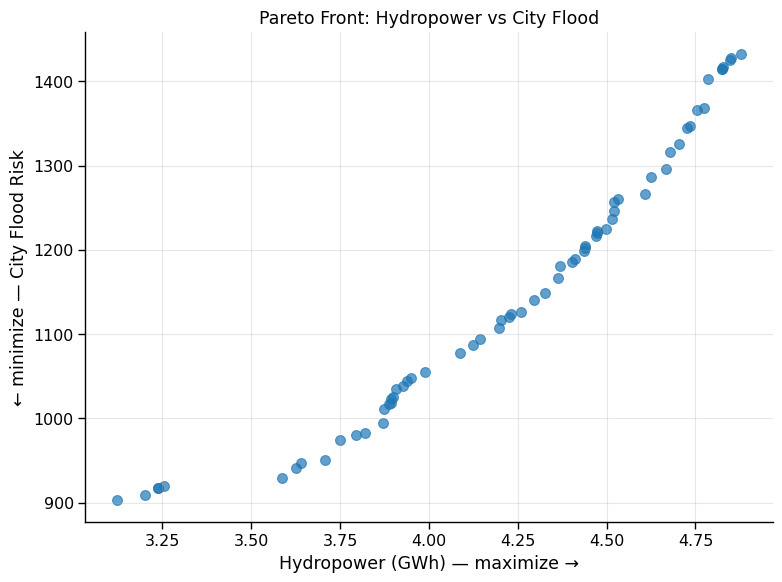


=== Pareto Front Statistics ===
Hydropower: 3.12 – 4.88 GWh (range: 1.76)
City Flood: 903.4 – 1432.4 (range: 529.0)
Correlation: 0.97 (positive = conflict with max/min directions)

=== Example Solutions ===
Strategy             Hydropower (GWh)   City Flood  
--------------------------------------------------
Minimum flood risk   3.12               903.4       
Balanced             4.33               1148.3      
Maximum power        4.88               1432.4      


In [9]:
sns.set_context("paper", font_scale=1.3)

# Extract objective scores
hp = np.array([s.scores["hydropower"] for s in result.solutions])
fl = np.array([s.scores["city_flood"] for s in result.solutions])

# Create simple Pareto front scatter
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(hp, fl, s=50, alpha=0.7)
ax.set_xlabel("Hydropower (GWh) — maximize →")
ax.set_ylabel("← minimize — City Flood Risk")
ax.set_title("Pareto Front: Hydropower vs City Flood")
ax.grid(True, alpha=0.3)
plt.tight_layout()
sns.despine()
plt.savefig("/Users/nicolaslazaro/Desktop/work/taqsim/figures/pareto", dpi=300, bbox_inches="tight")
plt.show()

# Summary statistics
print("\n=== Pareto Front Statistics ===")
print(f"Hydropower: {hp.min():.2f} – {hp.max():.2f} GWh (range: {hp.max() - hp.min():.2f})")
print(f"City Flood: {fl.min():.1f} – {fl.max():.1f} (range: {fl.max() - fl.min():.1f})")
print(f"Correlation: {np.corrcoef(hp, fl)[0, 1]:.2f} (positive = conflict with max/min directions)")

# Show example solutions
min_flood_idx = np.argmin(fl)
max_hp_idx = np.argmax(hp)
sort_idx = np.argsort(hp)
hp_sorted = hp[sort_idx]
fl_sorted = fl[sort_idx]
mid_idx = len(hp) // 2

print("\n=== Example Solutions ===")
print(f"{'Strategy':<20} {'Hydropower (GWh)':<18} {'City Flood':<12}")
print("-" * 50)
print(f"{'Minimum flood risk':<20} {hp[min_flood_idx]:<18.2f} {fl[min_flood_idx]:<12.1f}")
print(f"{'Balanced':<20} {hp_sorted[mid_idx]:<18.2f} {fl_sorted[mid_idx]:<12.1f}")
print(f"{'Maximum power':<20} {hp[max_hp_idx]:<18.2f} {fl[max_hp_idx]:<12.1f}")

In [10]:
result.solutions[0].parameters

{'reservoir.release_rule.h1[0]': 43.6422373036835,
 'reservoir.release_rule.h1[10]': 65.535250255877,
 'reservoir.release_rule.h1[11]': 41.04020988647871,
 'reservoir.release_rule.h1[1]': 31.61446456177455,
 'reservoir.release_rule.h1[2]': 51.6521318665101,
 'reservoir.release_rule.h1[3]': 29.479784116137544,
 'reservoir.release_rule.h1[4]': 20.02308972323712,
 'reservoir.release_rule.h1[5]': 48.33108168293221,
 'reservoir.release_rule.h1[6]': 26.595333130770882,
 'reservoir.release_rule.h1[7]': 27.678368800710523,
 'reservoir.release_rule.h1[8]': 28.687186518801493,
 'reservoir.release_rule.h1[9]': 20.0,
 'reservoir.release_rule.h2[0]': 97.15996008337298,
 'reservoir.release_rule.h2[10]': 98.39794071694062,
 'reservoir.release_rule.h2[11]': 95.8589623969672,
 'reservoir.release_rule.h2[1]': 74.99858574162107,
 'reservoir.release_rule.h2[2]': 75.23722610438082,
 'reservoir.release_rule.h2[3]': 95.75951071751382,
 'reservoir.release_rule.h2[4]': 90.01744764834672,
 'reservoir.release_ru